In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import statsmodels.api as sm
import RMA
import scipy.optimize as opt

In [4]:
import matplotlib as mpl

In [5]:
%matplotlib inline

In [6]:
mpl.rcParams['font.family']='serif'
mpl.rcParams['font.serif'] = 'Times'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['text.usetex']=True
mpl.rcParams['figure.figsize'] = (10,7.15)
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['legend.fontsize'] = 26
mpl.rcParams['legend.scatterpoints'] = 1
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markeredgewidth'] = 0
mpl.rcParams['figure.titlesize'] = 28
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['patch.linewidth'] = 0.5

In [7]:
data = pd.read_excel('../data/Supplementary_Data_Microprocessors.xls',header=1)

In [8]:
data1 = data[[u'Chip', u'f', u'V',u'P',u'lambda',u'N',u'Achip']]

In [9]:
data2 = data[[u'Chip.1', u'f.1', u'V.1', u'P.1',u'lambda.1', u'N.1', u'Achip.1']]

In [10]:
for c in data2.columns:
    name = c.split('.')[0]
    data2[name] = data2.loc[:,c]
    del data2[c]

/nfs/adaptive/bedwards/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [11]:
df = pd.concat([data1,data2.dropna()])

In [12]:
df['constant']= np.ones(len(df))
df['f'] = df['f']*10**6
df['size'] = df['lambda']*10**-9
del df['lambda']
df['N'] = df['N']*10**6

In [13]:
df.columns

Index([u'Chip', u'f', u'V', u'P', u'N', u'Achip', u'constant', u'size'], dtype='object')

In [14]:
df['logN'] = np.log10(df.N)
df['Tsys'] = 1.0/df.f

In [15]:
power_gls = sm.GLS(np.log10(df.P),df[['logN','constant']]).fit()

In [16]:
def theoretical_model(c,X):
    return c*(X**0.5)

In [17]:
def sq_dist(c,f,X,Y):
    fX = f(c,X)
    if np.any(fX < 0):
        return np.inf
    return ((np.log10(fX) - np.log10(Y))**2).sum()

In [18]:
cTheory = opt.fmin(sq_dist,x0=[50],args=(theoretical_model,df.N,df.P))

Optimization terminated successfully.
         Current function value: 24.558042
         Iterations: 37
         Function evaluations: 74


In [19]:
cTheory

array([ 0.00635147])

In [20]:
sN = np.sort(df.N.values)

In [21]:
power_gls.params

logN        0.495435
constant   -2.163100
dtype: float64

In [22]:
power_gls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                      P   R-squared:                       0.653
Model:                            GLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     979.9
Date:                Mon, 28 Dec 2015   Prob (F-statistic):          8.48e-122
Time:                        14:58:06   Log-Likelihood:                 57.746
No. Observations:                 523   AIC:                            -111.5
Df Residuals:                     521   BIC:                            -103.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
logN           0.4954      0.016     31.304      0.000         0.464     0.527
constant      -2.1631      0.118    -18.328      0.000        -2.395    -1.931
==============================================================================
Omnibus:                       55.092   Durbin-Watson:                   0.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.057
Skew:                          -0.841   Prob(JB):                     6.13e-16
Kurtosis:                       3.620   Cond. No.                         94.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
cgls = (10**power_gls.predict([df.logN.min(),1]))/(df.N.min()**0.5)

In [24]:
cgls

array([ 0.0066306])

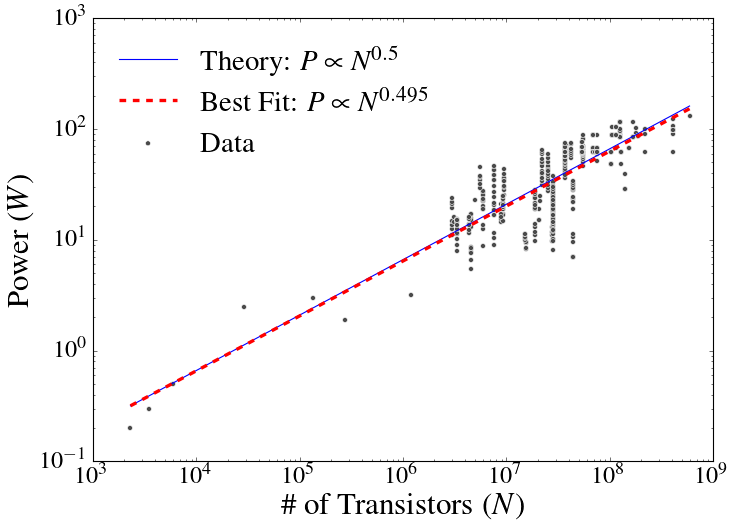

In [31]:
plt.scatter(df.N,df.P,color='#4A4A4A',marker='o',edgecolor='w',label='Data')
plt.loglog(sN,theoretical_model(cgls,sN),'b-',lw=1,label='Theory: $P \propto N^{0.5}$')
plt.loglog(sN,10**power_gls.predict(np.c_[np.log10(sN),df.constant]),'r--',lw=3,label='Best Fit: $P\propto N^{0.495}$')
plt.xlabel('\# of Transistors ($N$)')
plt.ylabel('Power ($W$)')
plt.legend(loc='upper left',frameon=False)
plt.savefig('../Figures/ChipsPowerScaling.pdf',dpi=600)

In [ ]:
sm.GLS(np.log(df.Tsys),df[['logN','constant']]).fit().summary()

In [ ]:
plt.loglog(df['size']**2,df.N,'k.')
plt.ylabel('# of Transistors')
plt.xlabel('Transistor Area ($m^2$)')

In [ ]:
df['lsize'] = np.log(df['size'])

In [ ]:
sm.GLS(np.log(df['N']),df[['lsize','constant']]).fit().summary()

In [ ]:
df[(df.f==300*10**6) & (df.N==7500000)]

In [ ]:
df[df.N > 10**6].f.max()/df[df.N > 10**6].f.min()

In [ ]:
df[df.N > 10**6]['size'].max()/df[df.N > 10**6]['size'].min()

In [ ]:
plt.loglog(df.N,df.P,'k.',label='Measured')
plt.loglog(df.N,3.9*(df.V**2)*df.N*((df['size']*10**-9)**1)*df.f,'r.',label='$P=\epsilon N \\times V^2 \\times Size \\times Freq$')
plt.xlabel('# of Transistors')
plt.ylabel('Power (W)')
plt.legend(loc='lower right')

In [ ]:
plt.loglog(df.N,df.P,'k.',label='Measured')
plt.loglog(df.N,df.N*((df['size']*10**-9)**1),'r.',label='$P=N \\times Size$')
plt.xlabel('# of Transistors')
plt.ylabel('Power (W)')
plt.legend(loc='center left')

In [ ]:
RMA.RMARegression(np.log(df.N),np.log(df.N*df['size']))

In [ ]:
RMA.RMARegression(np.log(df.N),np.log(df.P))

In [ ]:
plt.loglog(df.P,3.9*(df.V**2)*df.N*((df['size']*10**-9)**1)*df.f,'k.')
plt.loglog([.01,1000],[.01,1000],'r--',label='Equality')
#plt.loglog((df.V**2)*df.N*((df['size']*10**-9)**1)*df.f,'r.',label='$P=N \\times V^2 \\times Size \\times Freq$')
plt.xlabel('Measured Power')
plt.ylabel('Calculated Power\n$P=\epsilon N \\times V^2 \\times Size \\times Freq$')
#plt.xlim(1,1000)
#plt.ylim(1,1000)
plt.legend(loc='lower right')

In [ ]:
sm.GLM(np.log(df.P),df[['logN','constant']]).fit().summary()

In [ ]:
sm.GLM(np.log(df.f*df['size']*df.N),df[['logN','constant']]).fit().summary()

In [ ]:
RMA.RMARegression(np.log(df.N.values),np.log(df.P.values))

In [ ]:
RMA.RMARegression(np.log(df.N.values),np.log(df.N.values*df['size'].values*df.f.values))

In [ ]:
plt.loglog(df.N,df.Tsys,'k.')

In [ ]:
reload(RMA)

In [ ]:
RMA.RMARegression(np.log10(df.N.values),np.log10(df.f.values))

In [ ]:
RMA.RMARegression(np.log10(df.N.values),np.log10(df.Tsys.values))

In [ ]:
RMA.RMARegression(np.log(df.N),np.log(df['size'].values))

In [ ]:
RMA.RMARegression(2*np.log(df['size'].values),np.log(df.N))

In [ ]:
df.columns

In [ ]:
sm.GLM(np.log(df.N),np.c_[2*df.lsize.values,df.constant.values]).fit().summary()

In [ ]:
sm.GLM(np.log(df.f),np.c_[2*df.lsize.values,df.constant.values]).fit().summary()

In [ ]:
sm.GLM(np.log(df.P),np.c_[2*df.lsize.values,df.constant.values]).fit().summary()